In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import scanpy as sc

from sklearn.decomposition import PCA
from kneed import KneeLocator

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks",{'axes.grid' : True})

In [2]:
# Hyperparameters
path = "data/visium"  # Path to the Visium dataset
slide = "Visium_FFPE_V43T08-041_A"  # Slide to analyze
n_pcs_comp = 50  # Number of PCs to compute

/tmp/ipykernel_29517/1797537657.py:2: FutureWarning: Use `squidpy.read.visium` instead.
  adata = sc.read_visium(path=f"{path}/raw/{slide}/outs",
/home/vscode/.local/lib/python3.13/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/vscode/.local/lib/python3.13/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipykernel_29517/1797537657.py:11: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, frameon=False, ax=ax[0], show=False) # Without spots
/tmp/ipykernel_29517/1797537657.py:12: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, img_key="hires", alpha=0.1, frameon=False, ax=ax[1], show=False) # With spots


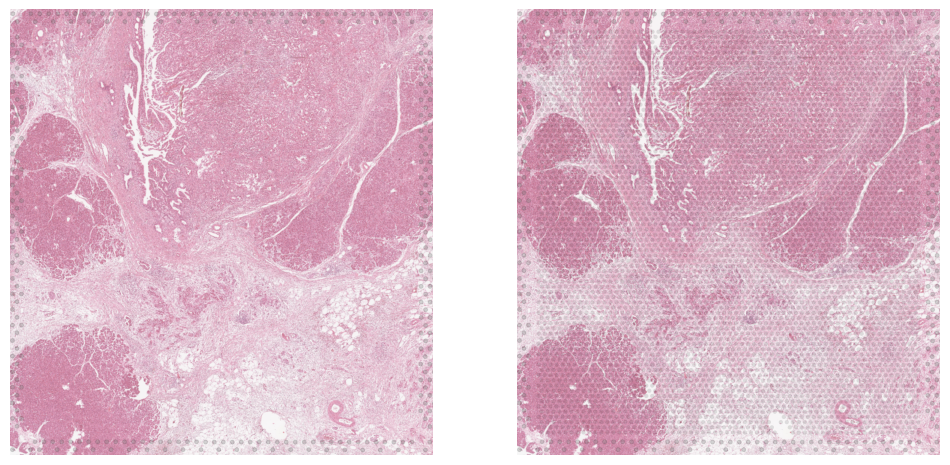

AnnData object with n_obs × n_vars = 4983 × 18085
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [3]:
# Load the anndata object
adata = sc.read_visium(path=f"{path}/raw/{slide}/outs",
                       count_file='filtered_feature_bc_matrix.h5',
                       load_images=True)

# Make the variables names unique
adata.var_names_make_unique()

# Plot the tissue sample
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sc.pl.spatial(adata, frameon=False, ax=ax[0], show=False) # Without spots
sc.pl.spatial(adata, img_key="hires", alpha=0.1, frameon=False, ax=ax[1], show=False) # With spots
plt.show()

adata

# What is the fraction of non-zero entries in the matrix?


In [4]:
non_zero_counts = adata.X.astype(bool).sum().sum()/np.prod(adata.X.shape)
print(f'The fraction of non-zero counts = {non_zero_counts:.4f}')

The fraction of non-zero counts = 0.2387


# T-cells and NK

/tmp/ipykernel_29517/1996341700.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, color=["CD8A", "CD3E"], frameon=False, cmap='Blues', alpha_img=0.5, size=0.8)


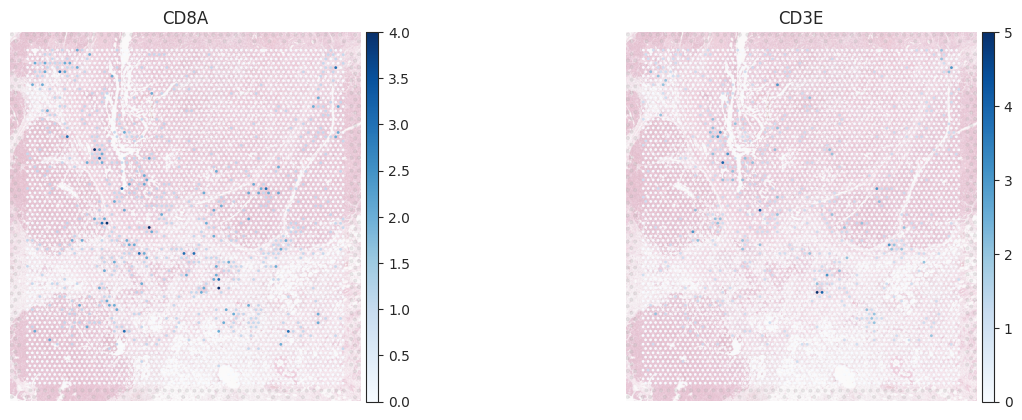

In [5]:
sc.pl.spatial(adata, color=["CD8A", "CD3E"], frameon=False, cmap='Blues', alpha_img=0.5, size=0.8)

## Basic filtering
* Filter out any gene expresed by less than 3 cells

In [6]:
sc.pp.filter_genes(adata, min_cells=10)

adata

AnnData object with n_obs × n_vars = 4983 × 18017
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

# Annotate mitochondrial genes as 'mt' and the ribosomal genes as 'ribo'
* Mitochondrial genes are taged with MT for human genes
* Ribosomal genes are not taged, so you have to compare the genes to a list of known ribosomal genes.

Ribosomal genes can be downloaded as csv from: https://www.gsea-msigdb.org/gsea/msigdb/human/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=CSV

In [7]:
# Annotate the metacondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-')

# How many different mitochondrial genes were observed?
print(f"Number of observed mitochondrial genes = {adata.var['mt'].sum()}")

# Read the list of ribosomal genes (88 genes) from a csv file
ribosomal_genes = pd.read_csv('KEGG_RIBOSOME.v2024.1.Hs.csv', skiprows=2, header=None)[0].values

# Annotate the ribosomal genes
adata.var['ribo'] = adata.var_names.isin(ribosomal_genes)

# How many different ribosomal genes were observed?
print(f"Number of observed ribosomal genes = {adata.var['ribo'].sum()}")

Number of observed mitochondrial genes = 11
Number of observed ribosomal genes = 2


In [8]:
# Remove the mitochondrial and ribosomal genes
adata = adata[:, ~adata.var['mt']]
adata = adata[:, ~adata.var['ribo']]

adata

View of AnnData object with n_obs × n_vars = 4983 × 18004
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'ribo'
    uns: 'spatial'
    obsm: 'spatial'

# Calculate the quality control metrics

In [9]:
# Calculate the QC metrics with respect to metacondrial and ribosomal genes
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
adata

/home/vscode/.local/lib/python3.13/site-packages/scanpy/preprocessing/_qc.py:144: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


AnnData object with n_obs × n_vars = 4983 × 18004
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'total_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'spatial'
    obsm: 'spatial'

# Violin and histogram plots of some QC metrics
* Number of genes expressed in the count matrix
* Total counts per cell
* Percentage of counts in mitochondrial genes
* Percentage of counts in ribosomal genes

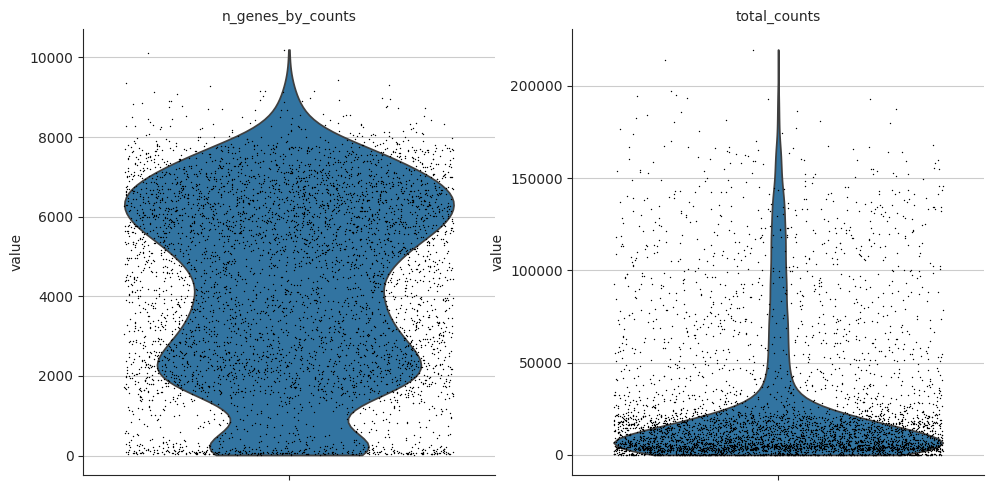

In [10]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)

# Filtering the low quality data

total counts boundaries = 30.95 -> 159330.61


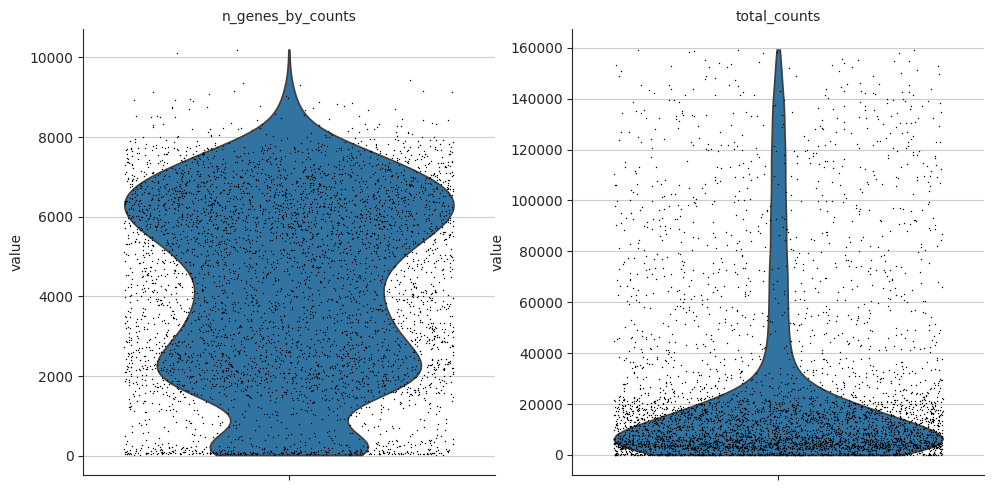

AnnData object with n_obs × n_vars = 4928 × 18004
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'total_counts', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'spatial'
    obsm: 'spatial'

In [11]:
# Adjust a threshould to filter outlayers
total_counts_upper = np.quantile(adata.obs.total_counts.values, .99)
total_counts_lower = np.quantile(adata.obs.total_counts.values, .001)

print(f"total counts boundaries = {total_counts_lower:.2f} -> {total_counts_upper:.2f}")

# Filter outlayers# Filtering the low quality data
sc.pp.filter_cells(adata, max_counts=total_counts_upper)
sc.pp.filter_cells(adata, min_counts=total_counts_lower)

# Plot the violin plot after filtering
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)

adata

# What are the highest expressed genes?

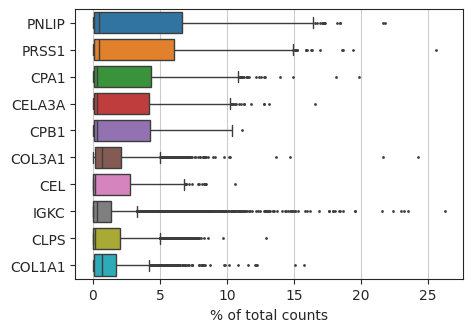

In [12]:
sc.pl.highest_expr_genes(adata, n_top=10)

# Plot the histogram of the most counted gene before and after normalization

Gene with the most counts is: PNLIP
With index = 9163


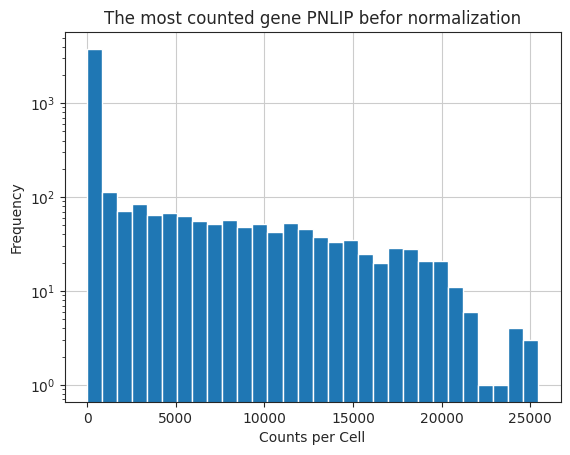

In [13]:
# Find the gene with the highest sum
gene_with_most_counts = adata.var_names[np.argmax(np.sum(adata.X, axis=0))]
print(f"Gene with the most counts is: {gene_with_most_counts}")

# Get the index of the gene in adata.var_names
gene_with_most_counts_index = list(adata.var_names).index(gene_with_most_counts)
print(f"With index = {gene_with_most_counts_index}")

# Plot the histogram
plt.hist(adata.X[:,gene_with_most_counts_index].toarray().flatten(), bins=30)
plt.title(f"The most counted gene {gene_with_most_counts} befor normalization")
plt.xlabel("Counts per Cell")
plt.ylabel("Frequency")
plt.yscale('log')
plt.show()

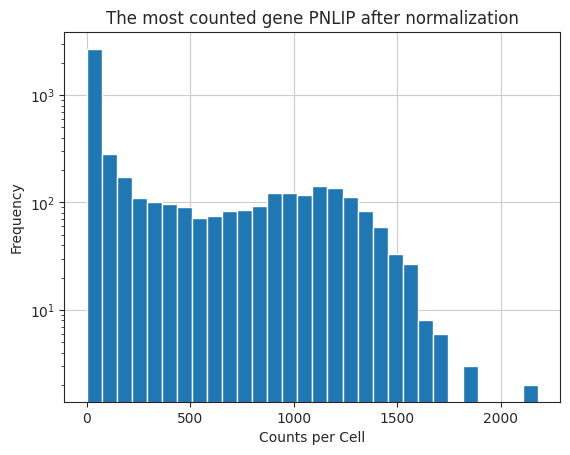

In [14]:
# Normalize the data so all cells has 10000 counts
sc.pp.normalize_total(adata, inplace=True, target_sum=1e4)

# Plot the histogram
plt.hist(adata.X[:,gene_with_most_counts_index].toarray().flatten(), bins=30)
plt.title(f"The most counted gene {gene_with_most_counts} after normalization")
plt.xlabel("Counts per Cell")
plt.ylabel("Frequency")
plt.yscale('log')
plt.show()

It looks like the normalization was harmfull on the highest gene but a carefull check on the other genes shows clearly that the normalization did a good job as expected.

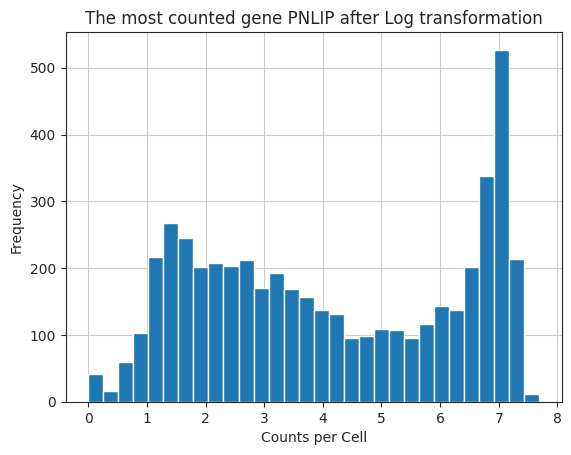

In [15]:
# Perform a log transformation
sc.pp.log1p(adata)

# Plot the histogram
plt.hist(adata.X[:,gene_with_most_counts_index].toarray().flatten(), bins=30)
plt.title(f"The most counted gene {gene_with_most_counts} after Log transformation")
plt.xlabel("Counts per Cell")
plt.ylabel("Frequency")
plt.show()

# Identify highly variable genes

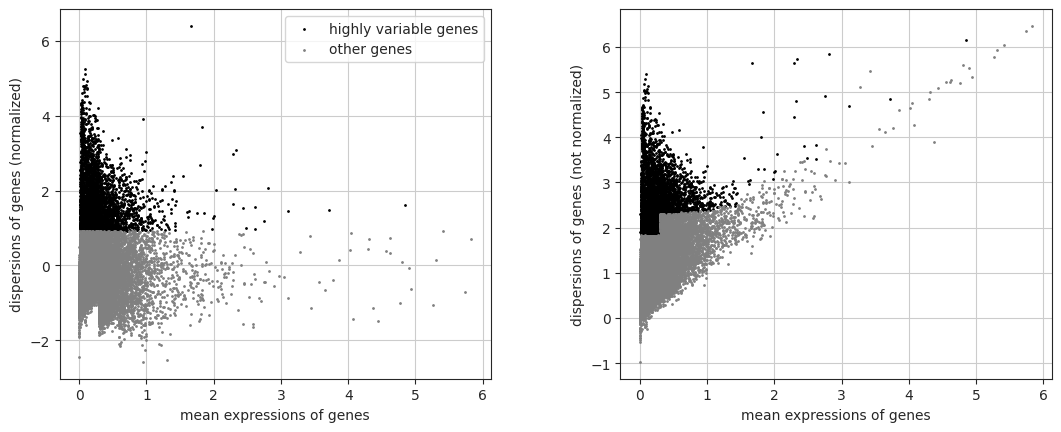

In [16]:
# Identifying the top highly variable genes in our data using seurat method.
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=3000)

# Visualize the results
sc.pl.highly_variable_genes(adata)

# Dimensionality reduction:
* Filtering out the low variable genes
* Apply principal component analysis (PCA)
* Reduce the dimensionality to 2 to visualize using Uniform Manifold Approximation and Projection (UMAP)

### Now, we can just work with these top highly variable genes

In [17]:
adata = adata[:, adata.var.highly_variable]

### Perform the PCA then find the numbere of PCs to be used with elbow dimension of the scree plot

/home/vscode/.local/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:379: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


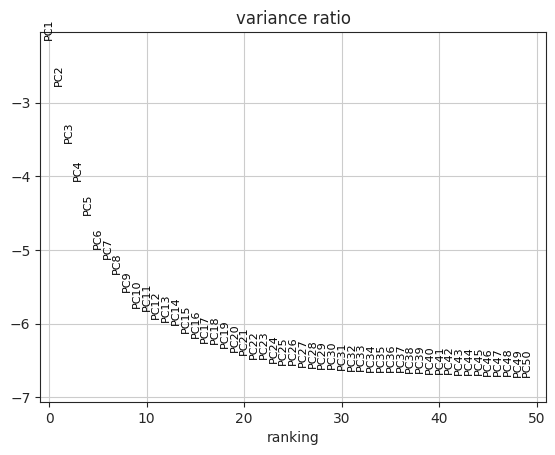

Explained variance ratio for the first 24 PCs = 0.29


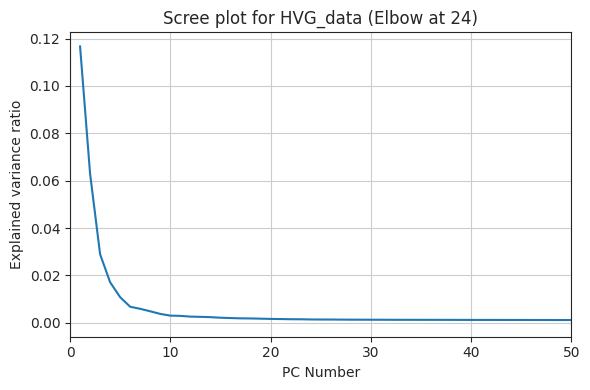

In [18]:
# Apply PCA to calculate 30 PCs
sc.pp.pca(adata, n_comps=n_pcs_comp)

# Plot the resulted graph
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=n_pcs_comp)

# Define the pca object then fit the PCA model on the extracted values from the HVGs dataframe
pca = PCA()
model = pca.fit(adata.X.toarray())

# Compute the explained variance for each gene
explained_variance = model.explained_variance_ratio_

# Enumerate the PC with the same dimension as the explained variance
pcs = list(range(1,explained_variance.shape[0]+1))

# Determine the number of PCs using KneeLocator then list them
kneelocator = KneeLocator(pcs, explained_variance, S=1.0, curve='convex', direction='decreasing')
n_pcs_used = kneelocator.knee

# Print the explained variance ratio
print(f"Explained variance ratio for the first {n_pcs_used} PCs = {explained_variance[:n_pcs_used].sum():.2f}")

# Plot how many PCs should be used
plt.figure(figsize = (6,4))
plt.plot(pcs, explained_variance)
plt.title(f"Scree plot for HVG_data (Elbow at {n_pcs_used})")
plt.xlabel("PC Number")
plt.ylabel("Explained variance ratio")
plt.xlim((0,n_pcs_comp))
plt.tight_layout()
plt.show()

# Computing the neighborhood graph

In [19]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=n_pcs_used)

# Performs Uniform Manifold Approximation and Projection (UMAP)

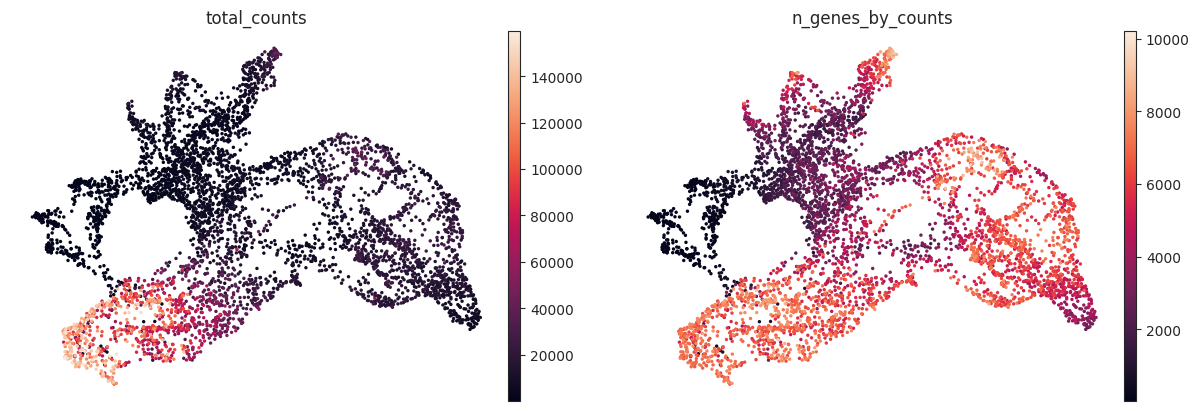

In [20]:
# Calculate the umap
sc.tl.umap(adata)

# Plot the umap graph with respect to the total counts and the number of genes
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts"], frameon=False)

# Clustering the neighborhood graph using leiden algorithm

/tmp/ipykernel_29517/1142833534.py:7: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, frameon=False, ax=axe[0], show=False) # Plot the clusters on the tissue
/tmp/ipykernel_29517/1142833534.py:9: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, color=['leiden'], frameon=False, ax=axe[1], show=False) # Plot the clusters on the tissue


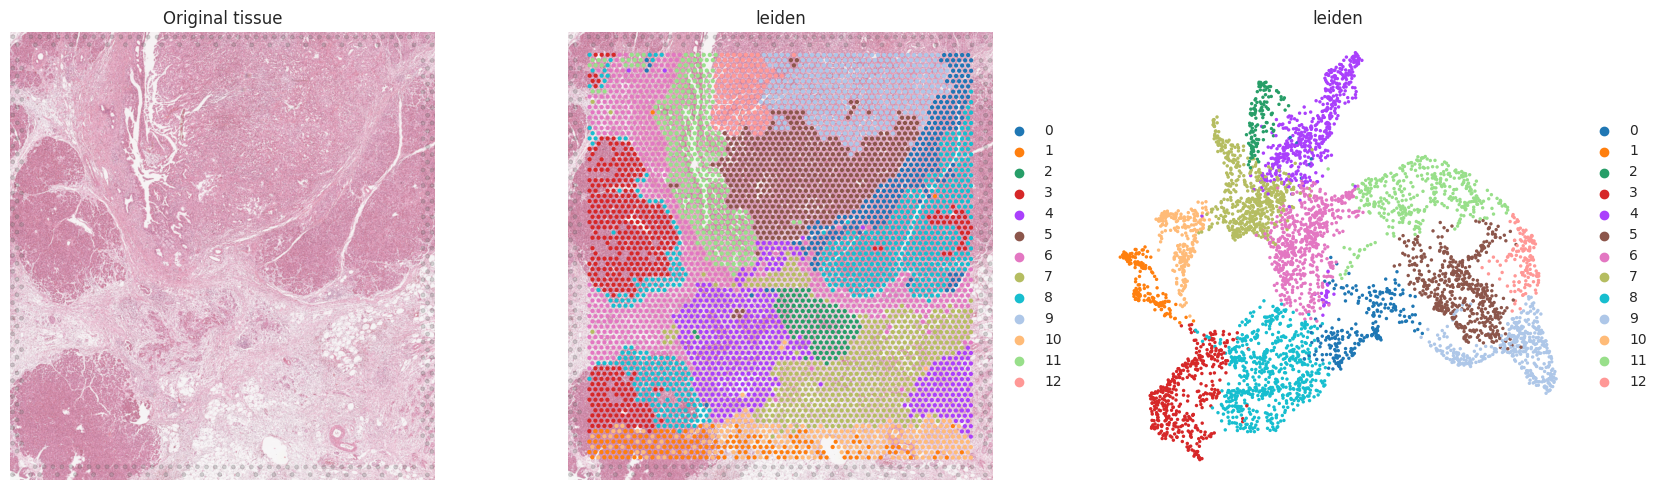

In [21]:
# Run leiden clustering
sc.tl.leiden(adata, resolution = 0.5, flavor='igraph', directed=False)

# Plot the clusters using umap
fig, axe = plt.subplots(1, 3, figsize=(17, 5), tight_layout=True)

sc.pl.spatial(adata, frameon=False, ax=axe[0], show=False) # Plot the clusters on the tissue
axe[0].set_title("Original tissue")
sc.pl.spatial(adata, color=['leiden'], frameon=False, ax=axe[1], show=False) # Plot the clusters on the tissue
sc.pl.umap(adata, color=['leiden'], ax=axe[2], frameon=False, show=False) # Plot the clusters

plt.show()

In [22]:
# Save the results
adata.write(f"{path}/results/{slide}_processed.h5ad")